# 04. Hyper‑parameter Optimization (Optuna) 
Notebook dedicado exclusivamente a la búsqueda de hiperparámetros para los
modelos multilabel de *Steel Plate Defect Prediction*.
 
* Dependencias clave: `optuna`, `lightgbm`, `scikit‑learn`, `hpo.py` (este repo).
* Resultado: archivos `best_params_<modelo>.json` + base de datos `.db` con el
  estudio completo dentro de `models/hpo/`.


In [31]:
# Imports y paths básicos
from pathlib import Path
import sys, os
import json
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [32]:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)
print(root)

C:\Users\ignag\OneDrive\Documentos\tfg_steel_plate_defects_v1


In [33]:
from src import ROOT_DIR
from src.models.hpo import run_hpo, HPO_DIR
from src.data.loading import load_data
from src.data.split import make_holdout_split
from src.pipeline.preprocessing import build_preprocessing_pipeline
from src.models.builders import build_estimator
from src.models.training import compute_pos_weights
from src.config import TARGET_COLS, RANDOM_STATE


# Metrica de optimización: Curva ROC-AUC.


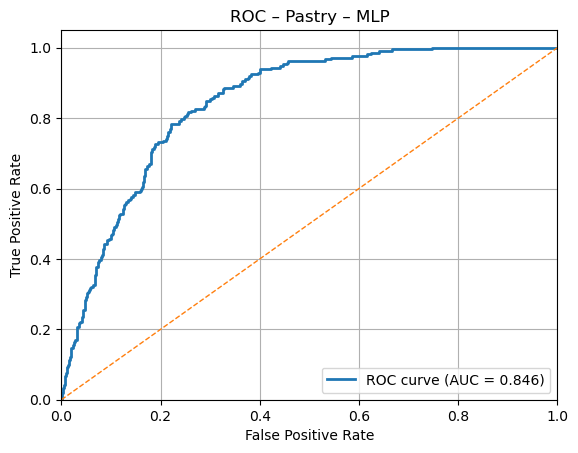

In [35]:
# ----------------------------------------------------------------------
MODEL_NAME = "mlp"      # "lgbm", "rf", "logreg", "mlp"
LABEL_ID   = 0           # 0=Pastry, 1=Z_Scratch, …, 6=Other_Faults
N_SPLITS   = 1           # entrenamos en todo el train salvo hold-out
# ----------------------------------------------------------------------

# 1. Carga y split básico ------------------------------------------------
X, y = load_data()
train_idx, test_idx = make_holdout_split(X, y)
y_train, y_test = y[train_idx], y[test_idx]

# 2. Preprocesado + modelo one-vs-rest para la etiqueta escogida ---------
pos_weights = compute_pos_weights(y_train)
preproc     = build_preprocessing_pipeline()

# solo la etiqueta que nos interesa
clf = build_estimator(MODEL_NAME, pos_weights)[LABEL_ID]

# Ajuste
X_train_p = preproc.fit_transform(X.iloc[train_idx])
X_test_p  = preproc.transform(X.iloc[test_idx])
clf.fit(X_train_p, y_train[:, LABEL_ID])

# 3. Predicciones y curva ROC -------------------------------------------
y_score = clf.predict_proba(X_test_p)[:, 1]
fpr, tpr, _ = roc_curve(y_test[:, LABEL_ID], y_score)
roc_auc = auc(fpr, tpr)

# 4. Plot ---------------------------------------------------------------
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")  # línea aleatoria
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC – {TARGET_COLS[LABEL_ID]} – {MODEL_NAME.upper()}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [36]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. Configuración 
Modifica el diccionario `CFG` para lanzar distintas búsquedas (modelo, nº de
ensayos, folds, etc.).

In [49]:
CFG = {
    "model_name": "logreg",   # opciones: 'lgbm', 'rf', 'logreg', 'mlp'
    "n_trials": 10,      # aumenta cuando tengas más tiempo/recursos
    "n_splits": 5,
}
print("Configuración:", CFG)

Configuración: {'model_name': 'logreg', 'n_trials': 10, 'n_splits': 5}


## 2. Lanzar la optimización
Esto puede tardar de minutos a horas según el número de *trials* y el modelo.
Los resultados quedan persistidos automáticamente, por lo que la celda es
**reentrante**: si la vuelves a ejecutar, sólo añadirá nuevos *trials*.

In [51]:
run_hpo(**CFG)

Best trial: 16. Best value: 0.85238: 100%|██████████| 10/10 [06:35<00:00, 39.53s/it]


Mejores hiperparámetros (limpios):
{
  "penalty": "l1",
  "C": 4.291057738420302
}

AUC media validación: 0.85238
Guardado en: reports\hpo\best_params_logreg.json


## 3. Cargar el estudio y analizar resultados
Aquí exploramos rápidamente el *study* generado para ver evolución de la
métrica y los diez mejores *trials*.

In [ ]:
study_name = f"hpo_{CFG['model_name']}"
study = optuna.load_study(
    study_name=study_name,
    storage=f"sqlite:///{HPO_DIR}/{study_name}.db",
)

# Tabla completa (opcional)
trials_df = study.trials_dataframe()
trials_df.head()

In [ ]:
# Plot de convergencia
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

# Diez mejores *trials*
cols = [c for c in trials_df.columns if c.startswith("params_") or c == "value"]
trials_df.sort_values("value", ascending=False).head(10)[cols]


## 4. Guardar/actualizar los mejores hiperparámetros


In [ ]:
best_params_path = HPO_DIR / f"best_params_{CFG['model_name']}.json"
with open(best_params_path) as fh:
    best_params = json.load(fh)

print("Best params loaded:")
print(json.dumps(best_params, indent=2))